In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_file = "multi_thread_thp.csv"

# read data and group by key_path, index_type, init_table_size, test_suite
original_csv = pd.read_csv(csv_file)

# group by as key_path index_type init_table_size test_suite
grouped_csv = original_csv.groupby(["key_path", "index_type", "init_table_size", "test_suite", "thread_num"])

# construct a new dataframe for each group
transformed_df = pd.DataFrame(
    columns=[
        #case
        "key_path",
        "index_type",
        "init_table_size",
        "test_suite",
        "thread_num",
        #result
        "insert_throughput_avg",
        "insert_throughput_min",
        "insert_throughput_max",
        "insert_throughput_stdv",
        "insert_throughput_cv",
        "read_throughput_avg",
        "read_throughput_min",
        "read_throughput_max",
        "read_throughput_stdv",
        "read_throughput_cv",
        "memory_consumption",
    ]
)
for name, group in grouped_csv:
    key_path, index_type, init_table_size, test_suite, thread_num = name
    insert_throughput_avg = group.loc[group["insert_ratio"] == 1, "throughput"].mean()
    insert_throughput_min = group.loc[group["insert_ratio"] == 1, "throughput"].min()
    insert_throughput_max = group.loc[group["insert_ratio"] == 1, "throughput"].max()
    insert_throughput_stdv = group.loc[group["insert_ratio"] == 1, "throughput"].std()
    insert_throughput_cv = insert_throughput_stdv / insert_throughput_avg
    read_throughput_avg = group.loc[group["insert_ratio"] == 0, "throughput"].mean()
    read_throughput_min = group.loc[group["insert_ratio"] == 0, "throughput"].min()
    read_throughput_max = group.loc[group["insert_ratio"] == 0, "throughput"].max()
    read_throughput_stdv = group.loc[group["insert_ratio"] == 0, "throughput"].std()
    read_throughput_cv = read_throughput_stdv / read_throughput_avg
    memory_consumption = group["memory_consumption"].mean()
    transformed_df.loc[len(transformed_df)] = [
        key_path,
        index_type,
        init_table_size,
        test_suite,
        thread_num,
        insert_throughput_avg,
        insert_throughput_min,
        insert_throughput_max,
        insert_throughput_stdv,
        insert_throughput_cv,
        read_throughput_avg,
        read_throughput_min,
        read_throughput_max,
        read_throughput_stdv,
        read_throughput_cv,
        memory_consumption,
    ]
# divide throughput by 1M
transformed_df["insert_throughput_avg"] /= 1e6
transformed_df["insert_throughput_min"] /= 1e6
transformed_df["insert_throughput_max"] /= 1e6
transformed_df["read_throughput_avg"] /= 1e6
transformed_df["read_throughput_min"] /= 1e6
transformed_df["read_throughput_max"] /= 1e6


In [14]:
sorted_insert_suites = [21, 31, 41, 51, 61, 71, 81, 91, 101, 111]

random_insert_suites = [22, 32, 42, 52, 62, 72, 82, 92, 102, 112]

bulk_load_whole_data_suites = 10

uniform_sampling_suites = [21, 22]

interval_sampling_suites = [31, 32, 33, 34, 35]

substring_sampling_suites = [41, 42, 51, 52, 61, 62, 71, 72]

zipfian_sampling_suites = [81, 82, 91, 92, 101, 102]

normal_sampling_suites = [111, 112]

pgm_sampling_suites = []

overall_test_suites = (
    uniform_sampling_suites + substring_sampling_suites + [bulk_load_whole_data_suites]
)

gap_size = 0.08

index_types = ["btree", "btreeolc", "art", "artolc", "alex", "alexolc","lipp", "lippolc", "dytis", "dili", "finedex", "sali"]

index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}

plt.rcParams.update({"font.size": 13})

index_colors = {
    "btree": "#4e7a96",
    "btreeolc": "#4e7a96",
    "art": "#b5ceb2",
    "artolc": "#b5ceb2",
    "alex": "LightBlue",
    "alexolc": "LightBlue",
    "lipp": "LightCoral",
    "lippolc": "LightCoral",
    "dytis": "#9467bd",
    "dili": "#fee08b",
    "finedex": "#ff7f0e",
    "sali": "LightCoral",
}

index_markers = {
    "btree": "o",
    "btreeolc": "o",
    "art": "d",
    "artolc": "d",
    "alex": "x",
    "alexolc": "x",
    "lipp": "1",
    "lippolc": "1",
    "dytis": "+",
    "dili": "*",
    "finedex": "*",
    "sali": "1"
}

df_new = transformed_df[transformed_df["test_suite"].isin(overall_test_suites)]


def get_official_name(str):
    if str == "btree":
        return "B+tree"
    elif str == "btreeolc":
        return "B+tree\nOLC"
    elif str == "art":
        return "ART"
    elif str == "artolc":
        return "ART\nOLC"
    elif str == "alex":
        return "ALEX"
    elif str == "alexolc":
        return "ALEX\nOLC"
    elif str == "lipp":
        return "LIPP"
    elif str == "lippolc":
        return "LIPP\nOLC"
    elif str == "dytis":
        return "DyTIS"
    elif str == "dili":
        return "DILI"
    elif str == "finedex":
        return "FineDex"
    elif str == "sali":
        return "SALI"
    elif str == "datasets/linear":
        return "Linear"
    elif str == "datasets/covid":
        return "Covid"
    elif str == "datasets/fb":
        return "Face"
    elif str == "datasets/fb-1":
        return "Face"
    elif str == "datasets/osm":
        return "OSM"


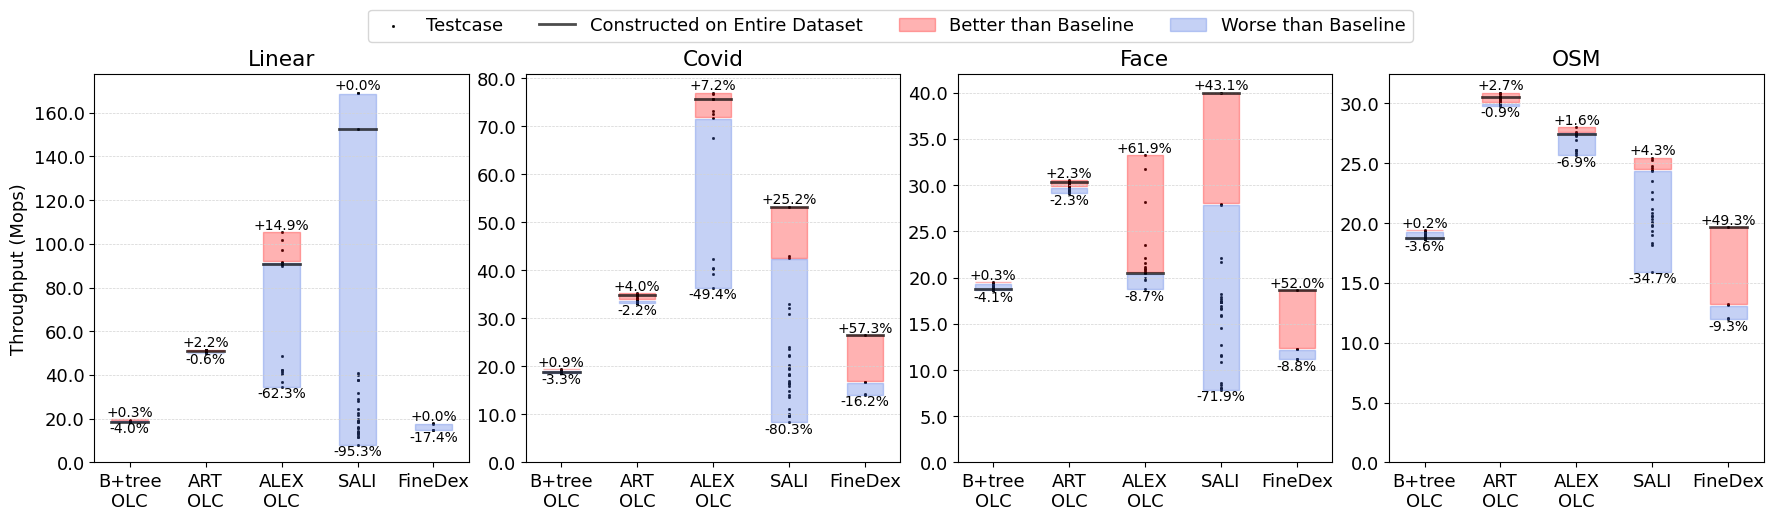

In [15]:
# figure: Overall Result
def get_scatter_style_final(row):
    """
    Determines the style for scatter plots based on the row data.

    Parameters:
    - row: DataFrame row containing the data for a particular data point.

    Returns:
    - color: Color of the scatter plot marker.
    - marker: Style of the marker.
    - linestyle: Style of the line.
    - label: Label for the legend.
    - size: Size of the marker.
    - offset: Offset for the marker position.
    """
    color = "black"
    edgecolor = "black"
    marker = "."
    size = 10
    linestyle = "-"
    linewidth = 0.5
    label = "Testcase"
    offset = 0

    return color, edgecolor, marker, linestyle, linewidth, label, size, offset


datasets = ["datasets/linear", "datasets/covid", "datasets/fb-1", "datasets/osm"]
index_types = ["btreeolc", "artolc", "alexolc","sali", "finedex"]
fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=False)

for i in range(len(datasets)):
    dataset = datasets[i]
    df_dataset = transformed_df[(transformed_df["key_path"] == dataset) 
                                & (transformed_df["index_type"].isin(index_types))
                                & (transformed_df["thread_num"] == 16)]

    baseline = df_dataset[
        (df_dataset["test_suite"] == 22) & (df_dataset["init_table_size"] == 100000000)
    ]
    #
    read_optimal = df_dataset[df_dataset["test_suite"] == bulk_load_whole_data_suites]
    read_throughput_bounds = df_dataset.groupby("index_type")[
        "read_throughput_avg"
    ].agg(["min", "max"])
    read_from_all_insert = df_dataset[(df_dataset["test_suite"] == 22)&(df_dataset["init_table_size"] == 0)]

    axs[i].set_title(get_official_name(dataset))

    if i == 0:
        axs[i].set_ylabel("Throughput (Mops)")

    axs[i].yaxis.grid(which="both", linestyle="--", linewidth=0.5, color="lightgrey")
    axs[i].set_ylim(bottom=0, top=df_dataset["read_throughput_avg"].max() * 1.05)

    axs[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))  # type: ignore

    index_type_to_num = {type_: i for i, type_ in enumerate(index_types)}
    for j in range(len(index_types)):
        axs[i].scatter(
            index_type_to_num[index_types[j]],
            0,
            color="white",
            linestyle="--",
            linewidth=0.01,
        )

    axs[i].set_xticks(range(len(index_types)))
    axs[i].set_xticklabels([get_official_name(index) for index in index_types])
    # read throughput scatter plot
    for j, row in df_dataset.iterrows():
        (
            color,
            edgecolor,
            marker,
            linestyle,
            linewidth,
            label,
            size,
            offset,
        ) = get_scatter_style_final(row)
        axs[i].scatter(
            index_type_to_num[row["index_type"]] + offset,
            row["read_throughput_avg"],
            color=color,
            edgecolor=edgecolor,
            label=label,
            s=size,
            marker=marker,
            linestyle=linestyle,
            linewidth=linewidth,
        )

    # read baseline
    for j in range(len(baseline)):
        if len(baseline["read_throughput_avg"])>j and len(read_optimal["read_throughput_avg"])>j:
            baseline_throughput = baseline["read_throughput_avg"].values[j]
            optimal_throuput = read_optimal["read_throughput_avg"].values[j]
            axs[i].plot(
                [
                    index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                    index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
                ],
                [optimal_throuput, optimal_throuput],
                label="Constructed on Entire Dataset",
                color="black",
                linestyle="-",
                linewidth=2,
                alpha=0.7,
            )
        # if(read_from_all_insert.size == 5):
        #     read_from_all_insert_throughput = read_from_all_insert["read_throughput_avg"].values[j]
        #     if(1):
        #         axs[i].plot(
        #             [
        #                 index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
        #                 index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
        #             ],
        #             [read_from_all_insert_throughput, read_from_all_insert_throughput],
        #             label="Read from All Inserts",
        #             color="Black",
        #             linestyle="--",
        #             linewidth=3,
        #             alpha=1,
        #         )

    # Add shaded area to scatterplot to indicate throughput bounds
    j = 0
    for _, (index_type, bounds) in enumerate(read_throughput_bounds.iterrows()):
        if baseline["index_type"].values[j] != index_type:
            continue
        baseline_throughput = baseline["read_throughput_avg"].values[j]
        # Fill area if upper bound exceeds baseline
        if bounds["max"] > baseline_throughput:
            axs[i].fill_between(
                [
                    index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                    index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
                ],
                baseline_throughput+axs[i].get_ylim()[1]*0.0022,
                bounds["max"],
                label="Better than Baseline",
                color="Red",
                alpha=0.3,
            )
            positive_percentage = (
                (bounds["max"] - baseline_throughput) / baseline_throughput * 100
            )
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["max"],
                f"+{positive_percentage:.1f}%",
                ha="center",
                va="bottom",
                size=10,
            )
        else:
            positive_percentage = 0.0
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["max"],
                f"+{positive_percentage:.1f}%",
                ha="center",
                va="bottom",
                size=10,
            )

        # Fill area if lower bound falls below baseline
        if bounds["min"] < baseline_throughput:
            axs[i].fill_between(
                [
                    index_type_to_num[baseline["index_type"].values[j]] - gap_size * 3,
                    index_type_to_num[baseline["index_type"].values[j]] + gap_size * 3,
                ],
                bounds["min"],
                baseline_throughput-axs[i].get_ylim()[1]*0.0022,
                label="Worse than Baseline",
                color="RoyalBlue",
                alpha=0.3,
            )
            negative_percentage = (
                (bounds["min"] - baseline_throughput) / baseline_throughput * 100
            )
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["min"],
                f"{negative_percentage:.1f}%",
                ha="center",
                va="top",
                size=10,
            )
        else:
            negative_percentage = 0.0
            axs[i].text(
                index_type_to_num[baseline["index_type"].values[j]],
                bounds["min"],
                f"{negative_percentage:.1f}%",
                ha="center",
                va="top",
                size=10,
            )
        j = j + 1

# Create legend with unique labels
handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

fig.legend(
    unique_labels.values(),
    unique_labels.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.06),
    ncol=5,
)
plt.tight_layout(w_pad=0.01)
plt.show()
# export pdf
fig.savefig("./fig/multi_thread_overall.pdf", bbox_inches="tight", transparent=True)

In [11]:
# table: Failed Case
import pandas as pd
import re
from collections import defaultdict

# 读取日志文件
with open('multi_thread_fail_case.log', 'r') as file:
    log_lines = file.readlines()

# 初始化数据结构
fail_data = defaultdict(lambda: defaultdict(int))

# 解析日志文件
for line in log_lines:
    index_match = re.search(r'Failed command: .* --index=(\w+)', line)
    test_suite_match = re.search(r'--test_suite=(\d+)', line)
    if index_match and test_suite_match:
        index = index_match.group(1)
        test_suite = test_suite_match.group(1)
        if 'Subprocess timeout' in line:
            reason = 'timeout'
        elif 'Subprocess failed with error code -11' in line:
            reason = 'error_code -11'
        elif 'Subprocess failed with error code -9' in line:
            reason = 'error_code -9'
        else:
            reason = 'other'
        fail_data[index]['failed'] += 1
        fail_data[index][reason] += 1
# 转换为Pandas DataFrame
data = []
for index, reasons in fail_data.items():
    fail_data[index]['total'] = 4
    row = {'index': index, 'total': reasons['total']}
    row.update(reasons)
    data.append(row)

df = pd.DataFrame(data)
df = df.fillna(0)  # 填充NaN值为0

# 打印结果
print(df)

     index  total  failed  timeout  error_code -11  error_code -9
0  alexolc      4      68      8.0            60.0            0.0
1  finedex      4     105      0.0           105.0            0.0
2     sali      4       9      0.0             0.0            9.0


In [12]:
# table: Worst Insert Result
# for all index_type, get the minimum insert throughput
df_insert_worst = df_new.groupby(["index_type", "key_path"])[
    "insert_throughput_avg"
].min()
df_insert_worst = df_insert_worst.reset_index()
df_insert_worst = df_insert_worst.sort_values(
    by=["key_path", "insert_throughput_avg"], ascending=[True, True]
)

pivot_df = df_insert_worst.pivot_table(
    index="key_path",
    columns="index_type",
    values="insert_throughput_avg"
)
print(pivot_df)

index_type        alexolc    artolc  btreeolc   finedex      sali
key_path                                                         
datasets/covid   2.301679  2.325499  1.329413  0.855770  0.383716
datasets/fb-1    1.179051  1.925853  1.331947  0.667762  0.449638
datasets/linear  1.343070  3.787660  1.331998  0.968376  0.691876
datasets/osm     1.343175  2.166593  1.331102  0.705197  0.185400
